## Import Kaggle - Original Notebook was in kaggle

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bbc-news-summary:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F24984%2F32267%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240621%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240621T101433Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7b6aec2b40b37d895d0822b34965c579ce3c8967b0dcd5fe81ea276b768e5c1b377a41addf5424617483480fb4786cc6d763ac55e262c595b7d4b72aa80b4614e96cb145eeff6dcaf4dbb784a9333a0d7910ff6bfc70006c18dfe05d0fb654484ce9056b39b0842f071418eb460c91b0a2ec19f185819f46c5f9d6babc234ad68c0ad81c413cc3848d36217394cf15e0e754f50ca8dc625f4330a97a91a012cc0be726a92277149bd0d9c453bd8f0efd4e91be1ba82928d7662802bbd4e5d8bedc9fcf261fe804cc489e7ddf3fc3ad8eb06662991bbee2db0396e5ce88c2be57f8ac0c2938f5219b7de89d8a77b2f4bbc1e15ad7d77a259ce7ca6200c55017b5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 9342346 bytes downloaded
Downloaded and uncompressed: bbc-news-summary
Data source import complete.


Some Pip Installs required *

In [2]:
!pip install bert-extractive-summarizer
!pip install contractions
!pip install evaluate rouge_score
!pip install gradio
!pip install accelerate -U

Imports

In [3]:
import pandas as pd
import os
import numpy as np
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.manifold import TSNE
# from rouge import Rouge
import transformers
from summarizer import Summarizer, TransformerSummarizer
import contractions
from sklearn.model_selection import KFold
from transformers import BigBirdPegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments
import torch
from datasets import Dataset
import gradio as gr
from transformers import PegasusForConditionalGeneration, TrainingArguments, AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
rouge = evaluate.load('rouge')


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# just to see the directory structure.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/bbc-news-summary/bbc news summary/BBC News Summary/News Articles/entertainment/384.txt
/kaggle/input/bbc-news-summary/bbc news summary/BBC News Summary/News Articles/entertainment/134.txt
/kaggle/input/bbc-news-summary/bbc news summary/BBC News Summary/News Articles/entertainment/293.txt
/kaggle/input/bbc-news-summary/bbc news summary/BBC News Summary/News Articles/entertainment/001.txt
/kaggle/input/bbc-news-summary/bbc news summary/BBC News Summary/News Articles/entertainment/211.txt
/kaggle/input/bbc-news-summary/bbc news summary/BBC News Summary/News Articles/entertainment/231.txt
/kaggle/input/bbc-news-summary/bbc news summary/BBC News Summary/News Articles/entertainment/335.txt
/kaggle/input/bbc-news-summary/bbc news summary/BBC News Summary/News Articles/entertainment/230.txt
/kaggle/input/bbc-news-summary/bbc news summary/BBC News Summary/News Articles/entertainment/184.txt
/kaggle/input/bbc-news-summary/bbc news 

### Create a Single Dataframe from all 5 categories of news.

In [5]:
# We need to create the dataframe and concatenate later.
def make_dataframes_from_file(text,summary):
    articles = {file for file in os.listdir(text) if file.endswith('.txt')}
    summaries = {file for file in os.listdir(summary) if file.endswith('.txt')}

    common_files = articles.intersection(summaries)
    # so that it matches the same files
    if len(common_files) != len(articles) or len(common_files) != len(summaries):
        raise ValueError("Source and target directories do not contain the same files.")

    records = []
    for filename in common_files:
        article_file_path = os.path.join(text, filename)
        summary_file_path = os.path.join(summary, filename)
        with open(article_file_path, 'r', encoding='latin-1') as article_file:
            article_text = article_file.read()

        with open(summary_file_path, 'r', encoding='latin-1') as summary_file:
            summary_text = summary_file.read()

        records.append({'article': article_text, 'summary': summary_text})
    df = pd.DataFrame.from_records(records)

    return df

Combine them

In [6]:
""" Loop thru the categories"""
categories = ['business', 'entertainment', "politics", "sport", "tech"]

base_article_path = "/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/"
base_summary_path = "/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/"

# Create dfs for all the categories (5)
dfs = [make_dataframes_from_file(f"{base_article_path}{category}", f"{base_summary_path}{category}") for category in categories]

# Concatenate all dfs
df = pd.concat(dfs, ignore_index=True)
df.head(5)

,article,summary
0,Lufthansa flies back to profit\n\nGerman airli...,German airline Lufthansa has returned to profi...
1,Dollar hits new low versus euro\n\nThe US doll...,The US dollar has continued its record-breakin...
2,US economy shows solid GDP growth\n\nThe US ec...,Growth was at an annual rate of 4% in the thir...
3,Warning over US pensions deficit\n\nTaxpayers ...,With the Pension Benefit Guaranty Corporation ...
4,US in EU tariff chaos trade row\n\nThe US has ...,"""Although the EU is a customs union, there is ..."


In [7]:
#check specific words
keyword = 'wal-mart'
filtered_df = df[df['summary'].str.contains(keyword, case=False)]
filtered_df

,article,summary
66,Wal-Mart to pay $14m in gun suit\n\nThe world'...,"""Although Wal-Mart has suspended gun sales in ..."
121,Mixed Christmas for US retailers\n\nUS retaile...,Upscale department store Nordstrom said same s...
182,Winn-Dixie files for bankruptcy\n\nUS supermar...,"Winn-Dixie, once among the most profitable of ..."
197,Macy's owner buys rival for $11bn\n\nUS retail...,US retail giant Federated Department Stores is...
238,Wal-Mart fights back at accusers\n\nTwo big US...,"Meanwhile, drugs group Eli Lilly is planning a..."
318,US consumer confidence up\n\nConsumers' confid...,"Wal-Mart, the largest US retailer, has said it..."
811,Wal-Mart is sued over rude lyrics\n\nThe paren...,Wal-Mart said it was investigating the claims ...


In [8]:
df.summary

0       German airline Lufthansa has returned to profi...
1       The US dollar has continued its record-breakin...
2       Growth was at an annual rate of 4% in the thir...
3       With the Pension Benefit Guaranty Corporation ...
4       "Although the EU is a customs union, there is ...
                              ...                        
2220    The blurring of boundaries between TV and the ...
2221    Many feel that the most difficult and challeng...
2222    Critics say the law would favour large compani...
2223    It has to be said if the game did not have the...
2224    But, however careful you may be, if the organi...
Name: summary, Length: 2225, dtype: object

In [9]:
df.head()

,article,summary
0,Lufthansa flies back to profit\n\nGerman airli...,German airline Lufthansa has returned to profi...
1,Dollar hits new low versus euro\n\nThe US doll...,The US dollar has continued its record-breakin...
2,US economy shows solid GDP growth\n\nThe US ec...,Growth was at an annual rate of 4% in the thir...
3,Warning over US pensions deficit\n\nTaxpayers ...,With the Pension Benefit Guaranty Corporation ...
4,US in EU tariff chaos trade row\n\nThe US has ...,"""Although the EU is a customs union, there is ..."


Some Cleaning with contractions and newlines spotted.

In [10]:
df=df.dropna()
def remove_newlines(text):
    return text.replace('\n', ' ')

df['article'] = df['article'].apply(remove_newlines)
df['summary'] = df['summary'].apply(remove_newlines)

def fix_contractions(text):
    return contractions.fix(text)

df['article'] = df['article'].apply(fix_contractions)
df['summary'] = df['summary'].apply(fix_contractions)

Train test val split

In [11]:

X = df['article']
Y = df['summary']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
train_df = pd.DataFrame({'article_text': X_train, 'summary_text': Y_train})
test_df = pd.DataFrame({'article_text': X_test, 'summary_text': Y_test})

# val set
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [12]:
train_df.shape

(1602, 2)

In [13]:
test_df.shape

(445, 2)

In [14]:
train_df.describe()

,article_text,summary_text
count,1602,1602
unique,1554,1528
top,More power to the people says HP The digital ...,CBI chief economist Ian McCafferty said the ec...
freq,2,2


In [15]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Remove punctuations, stop words, tokenize, etc.

In [16]:
# clean the data, remove common things in nlp.
stop_words = set(stopwords.words('english'))

def preprocess_text(text):

    tokens = word_tokenize(text)

    tokens = [token.lower() for token in tokens]
    # punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

train_df['articles'] = train_df['article_text'].apply(preprocess_text)
train_df['summaries'] = train_df['summary_text'].apply(preprocess_text)

train_df['articles'].head()


0       lufthansa flies back profit german airline luf...
1911    playstation 3 processor unveiled cell processo...
1902    ibm puts cash behind linux push ibm spending 1...
1690    robben sidelined broken foot chelsea winger ar...
601     grammys honour soul star charles memory soul l...
Name: articles, dtype: object

In [17]:
train_df.head()

,article_text,summary_text,articles,summaries
0,Lufthansa flies back to profit German airline...,German airline Lufthansa has returned to profi...,lufthansa flies back profit german airline luf...,german airline lufthansa returned profit 2004 ...
1911,PlayStation 3 processor unveiled The Cell pro...,"The Cell processor, which will drive Sony's Pl...",playstation 3 processor unveiled cell processo...,cell processor drive sony 's playstation 3 run...
1902,IBM puts cash behind Linux push IBM is spendi...,IBM said it had taken the step in response to ...,ibm puts cash behind linux push ibm spending 1...,ibm said taken step response greater customer ...
1690,Robben sidelined with broken foot Chelsea win...,Chelsea winger Arjen Robben has broken two met...,robben sidelined broken foot chelsea winger ar...,chelsea winger arjen robben broken two metatar...
601,Grammys honour soul star Charles The memory o...,His song Here We Go Again with Norah Jones won...,grammys honour soul star charles memory soul l...,song go norah jones record year best pop vocal...


Some Stats

In [18]:
train_df['article_length'] = train_df['articles'].apply(lambda x: len(x.split()))
train_df['summary_length'] = train_df['summaries'].apply(lambda x: len(x.split()))

print("Biggest length of articles:")
print(train_df['article_length'].max())

print("Average length of summaries:")
print(train_df['summary_length'].mean())

Max length of articles:
2258
Max length of summaryies:
1114
Average length of summaries:
104.08302122347067


## Histogram of article and summary length

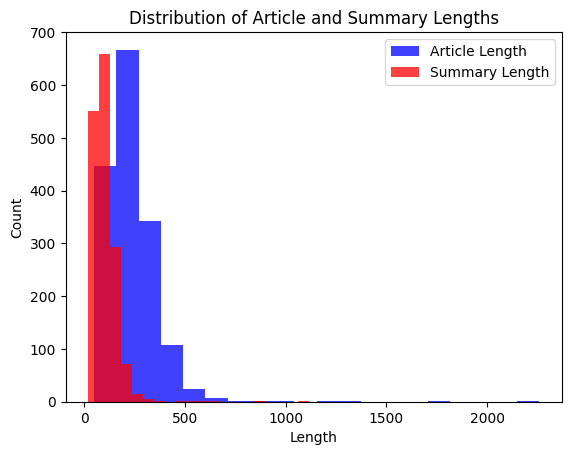

In [19]:
plt.hist(train_df['article_length'], bins=20, alpha=0.75, color='b', label='Article Length')
plt.hist(train_df['summary_length'], bins=20, alpha=0.75, color='r', label='Summary Length')
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Distribution of Article and Summary Lengths')
plt.legend()
plt.show()


## Find the most used words for a wordcloud later


Top 20 words by frequency:
             word  frequency
22822        said       7255
17682          mr       3005
28933        year       2309
19527      people       2045
18095         new       1978
26390        time       1322
28764       world       1201
11988  government       1160
27092          uk       1115
28937       years       1003
3841         best        974
14809        just        957
16358        make        945
26477        told        911
10641        film        890
15792        like        879
11455        game        871
17786       music        839
15275      labour        804
1             000        804


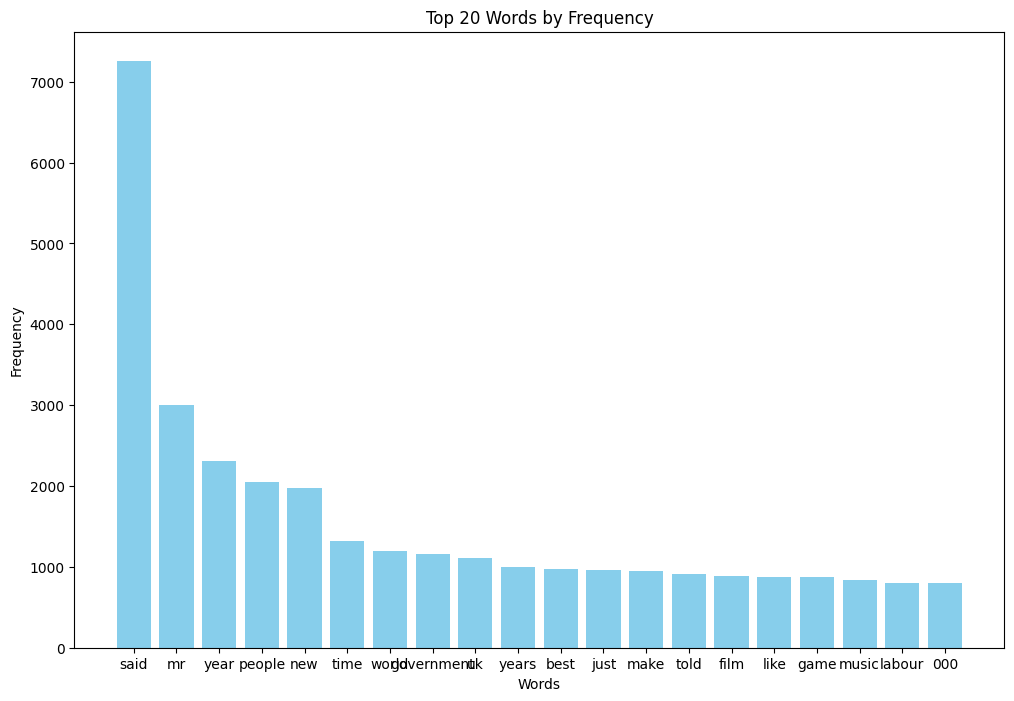

In [20]:
vectorizer = CountVectorizer(stop_words='english')

# transform the articles for counting
X = vectorizer.fit_transform(df['article'])
# sum
word_frequencies = X.sum(axis=0)

word_feats = vectorizer.get_feature_names_out()

# Create a DataFrame to store frequencies
word_freq_df = pd.DataFrame(word_feats, columns=['word'])

word_freq_df['frequency'] = word_frequencies.tolist()[0]

# Sort words by frequency
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# Display top 10 words by frequency
top_words = word_freq_df.head(20)
print("Top 20 words by frequency:")
print(top_words)

# Plotting top 20 words by frequency
plt.figure(figsize=(12, 8))
plt.bar(top_words['word'], top_words['frequency'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words by Frequency')
plt.show()

Finding cosine similarity between each article and summary

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Example DataFrame df with 'article_text' and 'summary_text' columns
# Assuming df['article_text'] and df['summary_text'] contain preprocessed text data

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform article_text and summary_text
X = vectorizer.fit_transform(df['article'])
Y = vectorizer.transform(df['summary'])

# Calculate cosine similarity between article_text and summary_text
cosine_similarities = cosine_similarity(X, Y)

# Example: Print cosine similarity score between the first article and its corresponding summary
print(f"Cosine similarity between first article and its summary: {cosine_similarities[1][1]}")


Cosine similarity between first article and its summary: 0.8398752597963478


## This is computational heavy so won't work, will figure another way

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarities, cmap='coolwarm', vmin=0, vmax=1,
            xticklabels=df['summary'], yticklabels=df['article'],
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Cosine Similarity between Articles and Summaries')
plt.xlabel('Summary Text')
plt.ylabel('Article Text')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Exception ignored in: <function _xla_gc_callback at 0x7fcb20945480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Error in callback <function flush_figures at 0x7fcc8d223a30> (for post_execute):


KeyboardInterrupt: 

In [23]:
cv= CountVectorizer(max_df= .6, min_df= .05, ngram_range= (1, 3))
X_cv= cv.fit_transform(df.article)
X_cv.shape

(2225, 975)

Visualization using TSNE

<Axes: >

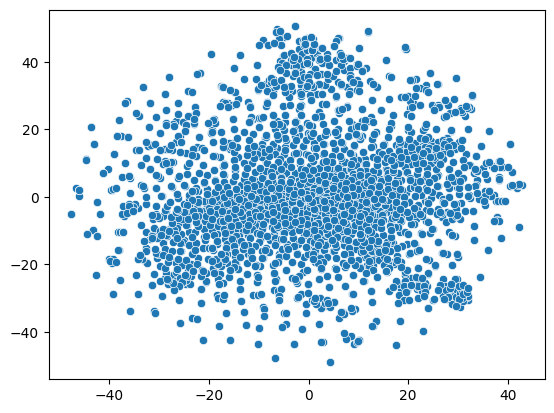

In [24]:
tsne = TSNE(n_components= 2, learning_rate= 'auto', init= 'random')
X_cv_tsne= tsne.fit_transform(X_cv)
sns.scatterplot(x= X_cv_tsne[:,0], y= X_cv_tsne[:,1])

Direct Apply BERT, GPT2, XLNet on a given text.

In [ ]:
model_bert = Summarizer()

model_gpt2 = TransformerSummarizer(transformer_type = "GPT2", transformer_model_key="gpt2-medium")

model_xlnet = TransformerSummarizer(transformer_type = "XLNet", transformer_model_key = "xlnet-base-cased")

In [25]:
df['article'][12]
text = 'Putin backs state grab for Yukos  Russia\'s president has defended the purchase of Yukos\' key production unit by state-owned oil firm Rosneft, saying it followed free market principles.  Vladimir Putin said it was quite within the rights of a state-owned company to ensure its interests were met. Rosneft bought 100% of Baikal Finance Group, in a move that amounts to the renationalisation of a major chunk of Russia\'s booming oil industry. Rosneft will now control about 16% of Russia\'s total crude oil output. Yukos share jumped in Moscow, climbing as much as 50% before being suspended.  Rosneft is already in the process of merging with Gazprom, the world\'s biggest gas company, a move that will see Gazprom return to majority state-ownership.  Baikal was the surprise buyer of oil and gas giant Yukos\'s main production division at a forced auction on Sunday. "Everything was done by market methods," Mr Putin said at his year-end press conference in Moscow. Shedding some light on the Kremlin\'s motivation, Mr Putin referred to a period of so-called "cowboy capitalism" that followed the collapse of the Soviet Union.  He said privatisations carried out in the early 1990s had involved trickery, including law breaking, by people seeking to acquire valuable state property. "Now the state, using market methods, is safeguarding its interests. I think this is quite normal," the Russian president said. A Rosneft spokesman has said the acquisition is part of its plan to build a "balanced, national energy corporation."  The latest announcement comes after more than a year of wrangling that has pushed Yukos, one of Russia\'s biggest companies to the brink of collapse. The Russian government put Yukos\'s Yuganskneftegas subsidiary up for sale last week after hitting the company with a $27bn (Â£14bn) bill for back taxes and fines.  Analysts say that Yukos\'s legal attempts to block the auction by filing for bankruptcy protection in the US are probably what caused this week\'s cloak-and-dagger dealings. Gazprom, the company originally tipped to buy Yuganskneftegas, was banned from taking part in the auction by a US court injunction. By selling the Yukos unit to little-known Baikal and then to Rosneft, Russia is able to circumvent a host of tricky legal landmines, analysts said. "You cannot sue the Russian government," said Eric Kraus, a strategist at Moscow\'s Sovlink Securities. "The Russian government has sovereign immunity." "The government is renationalising Yuganskneftegas."  Even so, analysts reckon that the saga still has a long way to go. The Rosneft announcement came just hours after Yukos accused Gazprom of illegally taking part in Sunday\'s auction. It has said it will be seeking damages of $20bn. The claim was made at the latest hearing in the US bankruptcy court in Houston, Texas, where Yukos, had filed for Chapter 11 bankruptcy protection. If found in contempt of the US court order blocking the auction, Gazprom could face having foreign assets seized. Yukos\' lawyers had also been expected to try to have Baikal\'s assets frozen. Lawyers claimed the auction was illegal because Yukos - with an office in Houston - had filed for bankruptcy and therefore its assets were under the protection of US law which has worldwide jurisdiction. Further muddying the waters is a merger between Rosneft and Gazprom which authorities have said will go ahead as planned. '

Summarizes the text using the models.

In [ ]:
summary_1 = ''.join(model_bert(text, min_length=50))
summary_2 = ''.join(model_gpt2(text, min_length=50))
summary_3 = ''.join(model_xlnet(text, min_length=50))

print(f'Summary by {model_bert}:\n\n{summary_1} \n\n')
print(f'Summary by {model_gpt2}:\n\n{summary_2} \n\n')
print(f'Summary by {model_xlnet}:\n\n{summary_3} \n\n')


## Load the MODEL - PEGASUS in this case.

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# mostly it's not available
# Load the pre-trained tokenizer and model
# tokenizer = PegasusTokenizer.from_pretrained('google/bigbird-pegasus-large-arxiv')
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv")
model = BigBirdPegasusForConditionalGeneration.from_pretrained('google/bigbird-pegasus-large-arxiv').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [27]:
device

device(type='cuda')

Constant prolem with google colab

In [ ]:
pip install accelerate -U


In [28]:
import accelerate
print(accelerate.__version__)


0.31.0


In [ ]:
!pip install transformers[torch] --upgrade

In [ ]:
import torch
print(torch.__version__)
# Delete a model
del model
torch.cuda.empty_cache()

In [29]:
# Tokenize the data
def tokenize_data(df):
    model_inputs = tokenizer(df['article_text'], max_length=524, truncation=True, padding='max_length')
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(df['summary_text'], max_length=128, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

train_dataset = train_df.apply(tokenize_data, axis=1).tolist()
val_dataset = val_df.apply(tokenize_data, axis=1).tolist()
test_dataset = test_df.apply(tokenize_data, axis=1).tolist()


# Define the training arguments
training_args = TrainingArguments(
    output_dir='./output',
    eval_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.1,
    save_total_limit=3,
    warmup_steps=500,
    save_strategy='epoch',
    remove_unused_columns=True,
    disable_tqdm=True,
    load_best_model_at_end=True,
    metric_for_best_model="rouge2"
)

# all rouge metrics
def compute_metrics(pred):
    # Example metrics using rouge for summarization
    return {
        'rouge1_precision': pred.metrics['rouge1'].precision,
        'rouge1_recall': pred.metrics['rouge1'].recall,
        'rouge1_fmeasure': pred.metrics['rouge1'].fmeasure,
        'rouge2_precision': pred.metrics['rouge2'].precision,
        'rouge2_recall': pred.metrics['rouge2'].recall,
        'rouge2_fmeasure': pred.metrics['rouge2'].fmeasure,
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# k-fold cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# to do
X_train = train_df['article_text'].values
Y_train = train_df['summary_text'].values

def train_fold(train_dataset, val_dataset):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    return trainer
train_fold(train_dataset, val_dataset)


result = trainer.evaluate(eval_dataset=test_dataset)
print(f"Final evaluation: {result}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Attention type 'block_sparse' is not possible if sequence_length: 524 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


{'loss': 5.8197, 'grad_norm': 1.8068251609802246, 'learning_rate': 0.005, 'epoch': 0.3121098626716604}
{'loss': 6.3102, 'grad_norm': 1.3469185829162598, 'learning_rate': 0.0027313974591651542, 'epoch': 0.6242197253433208}
{'loss': 5.9718, 'grad_norm': 1.380008339881897, 'learning_rate': 0.00046279491833030854, 'epoch': 0.9363295880149812}


OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB. GPU 

Total params

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
total_params

## RoUGE scores for evaluation

In [ ]:
# Compute ROUGE scores
rouge_results = trainer.compute_metrics(result)
print(f"ROUGE scores on test set:")
print(f"ROUGE-1 Precision: {rouge_results['rouge1_precision']}")
print(f"ROUGE-1 Recall: {rouge_results['rouge1_recall']}")
print(f"ROUGE-1 F-measure: {rouge_results['rouge1_fmeasure']}")
print(f"ROUGE-2 Precision: {rouge_results['rouge2_precision']}")
print(f"ROUGE-2 Recall: {rouge_results['rouge2_recall']}")
print(f"ROUGE-2 F-measure: {rouge_results['rouge2_fmeasure']}")

## Gradio Interface

In [ ]:

def summarize_article(article):

    inputs = tokenizer(article, return_tensors="pt", max_length=2048, truncation=True)

    # model generates the summary
    summary_ids = model.generate(inputs['input_ids'].to(device))

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

article_input = gr.Textbox(lines=10, label="Input article")
summarize_button = gr.Button(text="Summarize")

gr.Interface(
    fn=summarize_article,
    inputs=article_input,
    outputs=gr.Textbox(label="Summary", lines=12),
    title="Text Summarization",
    description="Paste and click Summarize",
    theme="compact"
).launch()


Using Model- T5 [Link](https://huggingface.co/docs/transformers/en/model_doc/t5)

In [ ]:
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)

In [ ]:
device = "cpu"

In [ ]:
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model.to(device)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")


In [ ]:
rouge = evaluate.load("rouge")

In [ ]:
# Training arguments (modify as per your requirements)
training_args = TrainingArguments(
    output_dir='./output',
    evaluation_strategy='epoch',
    learning_rate=1e-4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3,
    warmup_steps=500,
    save_steps=500,
    save_strategy='epoch',
    remove_unused_columns=False,
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="rouge2"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate on test set
test_result = trainer.evaluate(eval_dataset=test_dataset)
print(f"Final evaluation result on test set: {test_result}")